# Axisymmetric cylinder swelling

- Swelling of a gel cylinder
- This is an axisymmetric simulation

# Degrees of freedom
- Displacement: u
- pressure: p
- chemical potential: mu
- concentration: c

# Units
- Length: mm
- Mass: kg
- Time: s
- Mass density: kg/mm^3
- Force: milliN
- Stress: kPa 
- Energy: microJ
- Temperature: K
- Amount of substance: mol
- Species concentration: mol/mm^3
- Chemical potential: milliJ/mol
- Molar volume: mm^3/mol
- Species diffusivity: mm^2/s
- Gas constant: microJ/(mol K)

### Software:
- Dolfinx v0.8.0

In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [ ]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [ ]:
# Create mesh 
R0 = 2.5  # radius of bar
H0 = 2.5  # height of bar
domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0.0,0.0], [R0,H0]],\
                         [8,8], mesh.CellType.triangle, diagonal=mesh.DiagonalType.crossed)

x = ufl.SpatialCoordinate(domain)

**Identify boundaries of the domain**

In [ ]:
# Identify the boundaries of the  rectangle mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], R0)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], H0)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Identify the bottom left corner
def Ground(x):
        return np.isclose(x[0], 0) and np.isclose(x[1], 0)


# Build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Visualize reference configuration**

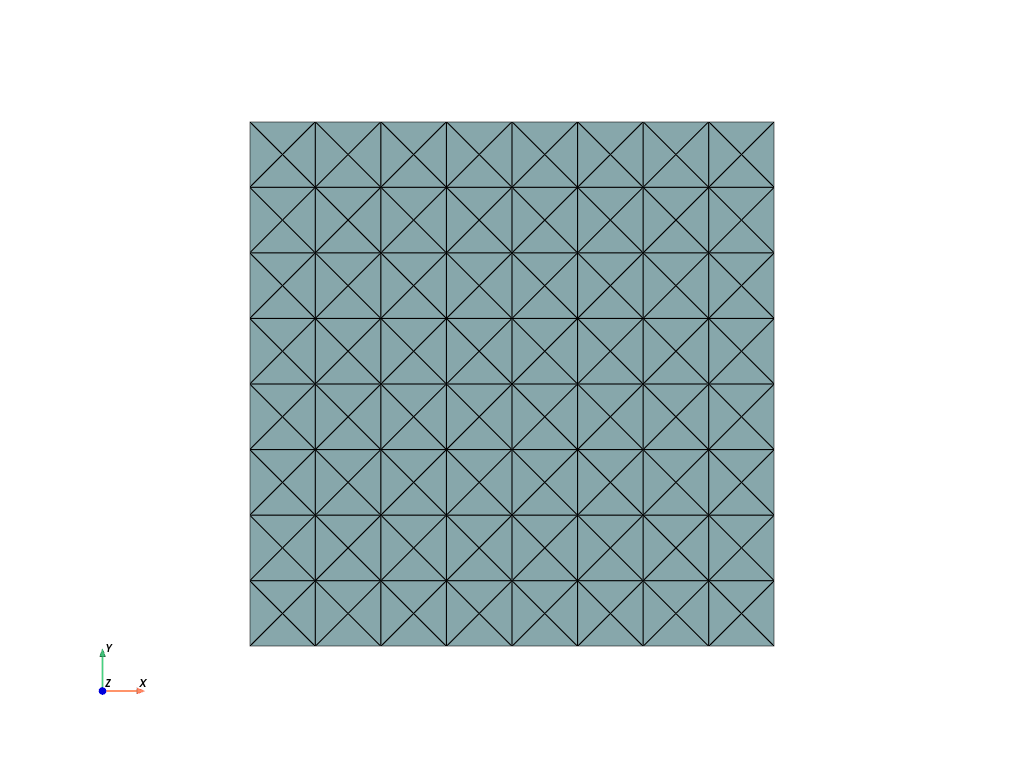

In [ ]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 

plotter.view_xy()

#labels = dict(xlabel='X', ylabel='Y',zlabel='Z')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/bar_mesh.png")

from IPython.display import Image
Image(filename='results/bar_mesh.png') 

# # Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("axi_cylinder_mesh.png")


## Define boundary and volume integration measure

In [ ]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 2})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parameters

In [ ]:
# Set the locking stretch to a large number to model a Neo-Hookean material
#
Gshear_0= Constant(domain,PETSc.ScalarType(1000.0))         # Shear modulus, kPa
lambdaL = Constant(domain,PETSc.ScalarType(100))            # Locking stretch, Neo-Hookean material
Kbulk   = Constant(domain,PETSc.ScalarType(1000*Gshear_0))  # Bulk modulus, kPa
Omega   = Constant(domain,PETSc.ScalarType(1.00e5))         # Molar volume of fluid
D       = Constant(domain,PETSc.ScalarType(5.00e-3))        # Diffusivity
chi     = Constant(domain,PETSc.ScalarType(0.1))            # Flory-Huggins mixing parameter
theta0  = Constant(domain,PETSc.ScalarType(298) )           # Reference temperature
R_gas   = Constant(domain,PETSc.ScalarType(8.3145e6))       # Gas constant
RT      = Constant(domain,PETSc.ScalarType(8.3145e6*theta0))
#
phi0    = Constant(domain,PETSc.ScalarType(0.999))                # Initial polymer volume fraction
mu0     = Constant(domain,PETSc.ScalarType(ln(1.0-phi0) + phi0 )) # Initial chemical potential
c0      = Constant(domain,PETSc.ScalarType((1/phi0) - 1))         # Initial concentration

# Simulation time-control related parameters

In [ ]:
t    = 0.0        # initialization of time
Ttot = 3600*6     # total simulation time 
ttd  = 300        # Decay time constant
dt   = 100        # Fixed step size

# Boundary condition expression for increasing  the chemical potential
#
def muRamp(t):
    return mu0*exp(-t/ttd)

# Function spaces

In [ ]:
# Define function space, both vectorial and scalar
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1) # For pressure, chemical potential and  species concentration
#                                      
TH = mixed_element([U2, P1, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)        # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, mu, c = split(w)  # displacement u, pressure p, chemical potential mu, and concentration c

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, mu_old, c_old = split(w_old)   

# Define test functions    
u_test, p_test,  mu_test, c_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Initial conditions

- The initial conditions for $\mathbf{u}$ and $p$ are zero everywhere.
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the uniform initial conditions for $\mu=\mu_0$ and $\hat{c} = \hat{c}_0$ which correspond to $\phi_0 = 0.999$. This is done below.

In [ ]:
# Assign initial  normalized chemical potential  mu0 to the domain
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  mu0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],), mu0))  

# Assign initial  value of normalized concentration  c0 to the domain
w.sub(3).interpolate(lambda x: np.full((x.shape[1],),  c0))
w_old.sub(3).interpolate(lambda x: np.full((x.shape[1],), c0))   

# Subroutines for kinematics and constitutive equations

In [ ]:
# Special gradient operators for axisymmetric functions 
#
#---------------------------------------------------
# Gradient of vector field u   
#---------------------------------------------------
def axi_grad_vector(u):
    
    grad_u = grad(u)
    
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
    
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, axi_grad_33_exp]]) 
    
    return axi_grad_u

#---------------------------------------------------
# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
#---------------------------------------------------
def axi_grad_scalar(y):
    
    grad_y = grad(y)
    
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
    
    return axi_grad_y
#---------------------------------------------------
# Axisymmetric deformation gradient 
#---------------------------------------------------
def F_axi_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
    
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
    
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
      
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
    
    return F_axi

#---------------------------------------------------
# Effective stretch lambdaBar
#---------------------------------------------------
def lambdaBar_calc(u):
    F = F_axi_calc(u)
    C = F.T*F
    I1 = tr(C)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

#---------------------------------------------------
# Calculate zeta
#---------------------------------------------------
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

#---------------------------------------------------
# Calculate zeta0
#---------------------------------------------------
def zeta0_calc():
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    z    = 1/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep from blowing up
    beta0 = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta0 = (lambdaL/3)*beta0
    return zeta0

#---------------------------------------------------
# Subroutine for calculating the elastic jacobian Je
#---------------------------------------------------
def Je_calc(u,c):
    F = F_axi_calc(u)  
    detF = det(F)   
    #
    detFs = 1.0 + c          # = Js
    Je    = (detF/detFs)     # = Je
    return   Je    

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u,p):
    F     = F_axi_calc(u)
    zeta  = zeta_calc(u)
    zeta0 = zeta0_calc()
    Piola = (zeta*F - zeta0*inv(F.T) ) - J*p*inv(F.T)/Gshear_0
    return Piola

#--------------------------------------------------------------
# Subroutine for calculating the normalized species flux
#--------------------------------------------------------------
def Flux_calc(u, mu, c):
    F = F_axi_calc(u) 
    #
    Cinv = inv(F.T*F) 
    #
    Mob = (D*c)/(Omega*RT)*Cinv
    #
    Jmat = - RT* Mob * axi_grad_scalar(mu)
    return Jmat

In [ ]:
##A.FLowers Comments

# Special gradient operators for axisymmetric functions 
#---------------------------------------------------
# Gradient of vector field u   
#---------------------------------------------------
def axi_grad_vector(u):
##Used in axissymmetric FE modeling to compute modified gradient of a vector field    
    grad_u = grad(u)
##u= scalar function; grad(u)= vector gradient. given in Jacobian matrix
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
##Used to compute the hoop strain; Cyndrical coordinates
##Scalar expression represents (3,3) component of axisymmetric deformation gradient / strain tensor
##Avoids division by zero at the axis point of r=0
    
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
##gradient tensor from 2D axisymmetric displacement field
##Gradient of radial displacement (r)
                  [grad_u[1,0], grad_u[1,1], 0],
##Gradient of axial displacement (z)
                  [0, 0, axi_grad_33_exp]]) 
##Hoop strain in circumferential direction; this is from the symmetry (theta)
    return axi_grad_u
##Gives 3x3 tensor representing full displacement gradient in axisymmetric coordinates

#---------------------------------------------------
# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
#---------------------------------------------------
def axi_grad_scalar(y):
##Defining function for scalar FEniCS    
    grad_y = grad(y)
##Standard gradient computed from scalar field y; this is 2D vector in (r,z) plane    
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
##Pads 2D gradient with zero in theta-direction; 3D vector in cylindircal coordinates (r,z,theta)    
    return axi_grad_y                                    
##Gives 3D gradient vector

#---------------------------------------------------
# Axisymmetric deformation gradient 
#---------------------------------------------------
def F_axi_calc(u):
    
    dim = len(u)                # dimension of problem (2)  
##u= 2D displacement field
    Id = Identity(dim)          # 2D Identity tensor
##Creates 2x2 identity tensor
    F = Id + grad(u)            # 2D Deformation gradient
##Defines 2D deformation gradient
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
##Computes circumferential stretch. Term reflects hoop (theta) stretch due to radial displacement 
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
##Avoids division by zero
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
##Builds 3x3 deformation gradient in cylindrical coordinates
    return F_axi
##Gives tensor for use in strain energy and stress

#---------------------------------------------------
# Effective stretch lambdaBar
#---------------------------------------------------
def lambdaBar_calc(u):
    F = F_axi_calc(u)
##Computes 3x3 deformation gradient tensor F for axisymmetric
    C = F.T*F
##Computers right Cauchy-Green deformation tensor; measuring stretch relative to reference configuration, used in finite strain elasticity
    I1 = tr(C)
##First invariant of C; represents sum of squared prinipal stretches
    lambdaBar = sqrt(I1/3.0)
##Computes isochoric (Volume-preserving) average stretch
##Invariant under rotation and insensitive to volumetric changes when in isocheric energy term
    return lambdaBar
##Gives scalar effective stretch value

#---------------------------------------------------
# Calculate zeta
#---------------------------------------------------
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u) # Use Pade approximation of Langevin inverse
##Computes isochoric effective stretch
    z    = lambdaBar/lambdaL
##Limit stretch of polymer chains; closer value is to 1, closer it is to max. extension, with the material becoming more stiff
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
##Numerical safegaurd to prevent blow-up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
##Pade approx. of inverse Langevin; used to relate average chain stretch to applied force in non-Gaussian polymer models
    zeta = (lambdaL/(3*lambdaBar))*beta
##Scales material response entering stress calculation in Gent or Arruda-Boyce models; rescales beta
    return zeta
##Gives scalar, varying deformation and reflects finite extensibility of polymer chains

#---------------------------------------------------
# Calculate zeta0
#---------------------------------------------------
def zeta0_calc(): # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    z    = 1/lambdaL
##Limit stretch of polymer chain
    z    = conditional(gt(z,0.95), 0.95, z) # Keep from blowing up
##Numerical safegaurd; ensuring numerical stability
    beta0 = z*(3.0 - z**2.0)/(1.0 - z**2.0)
##Pade approx. of inverse Langevin; representing stretch energy per chain
    zeta0 = (lambdaL/3)*beta0
##Initial modulus scaling factor from chain; finite extensibility correction factor
    return zeta0
##Gives constant value; used to enforce zero-stress reference

#---------------------------------------------------
# Subroutine for calculating the elastic jacobian Je
#---------------------------------------------------
def Je_calc(u,c):
    F = F_axi_calc(u)  
##Computes axisymmetric deformation gradient F of displacement field
    detF = det(F)   
##Computes total volume ratio; how much element has expanded / compressed compared to reference volume 
    detFs = 1.0 + c          # = Js
##Define swelling volume ratio
##c= swlling-related variable; 1+c= volume expansion due to chemical absorption
    Je    = (detF/detFs)     # = Je
##Computes elastic volume change; mechanical deformation after accounting for volume change from swelling
    return   Je    
##Gives mechanical output of deformation
##Used for elastic energy density functions, stress calculations, and thermodynamic coupling with chemical potentials

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u,p):
    F     = F_axi_calc(u)
##Computes deformation gradient F in axisymmetric coordinates from displacement field
    zeta  = zeta_calc(u)
##Computes scalar energy quantity (either osmotic pressure of chemical potential energy) 
    zeta0 = zeta0_calc()
##Reference value, in undeformed or initial state
    Piola = (zeta*F - zeta0*inv(F.T) ) - J*p*inv(F.T)/Gshear_0
##Enforce incompressibility (volumetric constraints) common in gel mechanics or incompressible elasticity
    return Piola
##Gives full, first Piola-Kirchhoff stress tensor P

#--------------------------------------------------------------
# Subroutine for calculating the normalized species flux
#--------------------------------------------------------------
def Flux_calc(u, mu, c):
    F = F_axi_calc(u) 
##Computes deformation gradient tensor F in axisymmetric coordinates; measuring stretch and shear
    Cinv = inv(F.T*F) 
##Computes inverse of right Cauchy-Green deformation tensor
##Geometric nonlinearity due to large deformation; helps transform diffusivity / mobility from reference configuration to the current 
    Mob = (D*c)/(Omega*RT)*Cinv
##Defines effective mobility tensor M; modifies diffusion based on deformation
    Jmat = - RT* Mob * axi_grad_scalar(mu)
##Computes flux via Fick's Law (chemical potential, not concentration)
##Species flux in material coordinates driven by chemical potential gradients modulated by deformation, concentration, and thermal energy
    return Jmat
##Gives reference configuration material flux vector


# Evaluate kinematics and constitutive relations

In [ ]:
# Kinematics
F = F_axi_calc(u)
J = det(F)  # Total volumetric jacobian
#
lambdaBar = lambdaBar_calc(u)
#
# Elastic volumetric Jacobian
Je     = Je_calc(u,c)                    
Je_old = Je_calc(u_old,c_old)

#  Normalized Piola stress
Piola = Piola_calc(u, p)

#  Normalized species  flux
Jmat = Flux_calc(u, mu, c)


In [ ]:
##A.Flowers Comments 

# Kinematics
F = F_axi_calc(u)
##Computes deformation gradient tensor F from displacement field in axisymmetric coordinates; captures stretch and shear from displacement
J = det(F)  # Total volumetric jacobian
##Total Jacobian determinant measuring volume change due to deformation; ratio of current to referene volume
##J couples with pressure in incompressibility and appears in transport models (such as osmosis) as coupling between defomration and chemical concetration

lambdaBar = lambdaBar_calc(u)
# Elastic volumetric Jacobian
Je     = Je_calc(u,c)
##Elastic Jacobian at present time; mechanical volume change, excluding swelling
Je_old = Je_calc(u_old,c_old)
##Elastic Jacobian at previous time; shows evolution

#  Normalized Piola stress
Piola = Piola_calc(u, p)
##Computes total stress in material using displacement and pressure field; then used in momentum balace, determining response under deformation and swelling

#  Normalized species  flux
Jmat = Flux_calc(u, mu, c)
##Computes species flux vector; considers deformation, chemical potential, and concentration. Pertinent to chemical transport in deforming materials (swelling gels) where mechanics and diffusion are coupled
##Flux of mobile species (solvent and ions); how fast they are moving through material, driven by chemical potential gradients and modified by mechanical deformation
##C evolves through mass conservation (diffusion)


# Weak forms

In [ ]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Pressure variable (test fxn: p)
# Res_2: Balance of mass   (test fxn: mu)
# Res_3: Auxiliary variable (test fxn: c)

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))

# The weak form for the equilibrium equation
Res_0 = inner(Piola, axi_grad_vector(u_test) )*x[0]*dx 

# The weak form for the pressure
Res_1 = dot((p*Je/Kbulk + ln(Je)) , p_test)*x[0]*dx
      
# The weak form for the mass balance of solvent      
Res_2 = dot((c - c_old)/dk, mu_test)*x[0]*dx \
        -  Omega*dot(Jmat , axi_grad_scalar(mu_test) )*x[0]*dx

# The weak form for the concentration
fac = 1/(1+c)
fac1 =  mu - ( ln(1.0-fac)+ fac + chi*fac*fac)
fac2 = - (Omega*Je/RT)*p  
fac3 = - (1./2.) * (Omega/(Kbulk*RT)) * ((p*Je)**2.0)
fac4 = fac1 + fac2 + fac3
#
Res_3 = dot(fac4, c_test)*dx
        
# Total weak form
Res = Res_0 + Res_1 + Res_2 + Res_3

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

In [ ]:
##A.Flowers Comments

# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Pressure variable (test fxn: p)
# Res_2: Balance of mass   (test fxn: mu)
# Res_3: Auxiliary variable (test fxn: c)

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))
##Defines constant scalar due to FEniCS (time step size)

# The weak form for the equilibrium equation
Res_0 = inner(Piola, axi_grad_vector(u_test) )*x[0]*dx 
##Computes double contraction (Frobenius) between stress tensor and gradient; internal virtual work density at a material point
##Main driving force of displacement solution under swelling and pressure

# The weak form for the pressure
Res_1 = dot((p*Je/Kbulk + ln(Je)) , p_test)*x[0]*dx
##Adds term to pressure residual enforcing compressibility / volume constraint via pressure, elastic volume change, and bulk modulus
##p=pressure field (unknown) acting as Lagrange multiplier; apperas when pressure is solved as a field, and is not given (balancing swelling and elasticity)

# The weak form for the mass balance of solvent      
Res_2 = dot((c - c_old)/dk, mu_test)*x[0]*dx \
##Weak form of transient accumulation of mobile species
        -  Omega*dot(Jmat , axi_grad_scalar(mu_test) )*x[0]*dx
##Weak form of divergence of flux; drives species redistribution due to chemical gradients and deformation
##Overall enforces chemical species conservation; change in concentration = inflow/outflow due to chemical potential gradients accounting for deformation of medium and axisymmetric geometry

# The weak form for the concentration
fac = 1/(1+c)
##Computes volume fraction of polymer
fac1 =  mu - ( ln(1.0-fac)+ fac + chi*fac*fac)
##Encodes Flory-Huggins chemical potential
fac2 = - (Omega*Je/RT)*p  
##Accounts for mechanical pressure contribution due to chemical potential
fac3 = - (1./2.) * (Omega/(Kbulk*RT)) * ((p*Je)**2.0)
##Compressibility correction due to bulk deformation from free energy stored
fac4 = fac1 + fac2 + fac3
##Residual contributions; difference between computed chemical potential and its theoretical value based on thermodynamics, mechanics, and compressibility

Res_3 = dot(fac4, c_test)*dx
##Residual term in variational form for solving chemical potential-concentration coupling in swelling gel model
##Thermodynamic consistency condition; ensures chemical potential used in flux equation is thermodynamically correct, given concentration and mechanical state
##Nonlinear coupled system, with momentum balance, mass transport, and thermodynamic closure

# Total weak form
Res = Res_0 + Res_1 + Res_2 + Res_3
##Total residual of FE; combining mechanics, thermodynamics, and mass transport in a swelling gel model
##Formula enabling coupled multiphysics behavior; characteristics in swelling gels, ionic polymers, hydrogel actuators

# Automatic differentiation tangent:
a = derivative(Res, w, dw)
##Solves nonlinear variational problem in FEniCS, computing Jacobian matrix


# Set-up output files

In [ ]:
# Set up projection problem for fixing visualization issues
# of fields in  the axisymmetric simulation
#
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*x[0]*dx
    L = ufl.inner(u, test)*x[0]*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

In [ ]:
# results file name
results_name = "gel_axi_swell"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(2,))  # For 2d vector
P0 = element("DG", domain.basix_cell(), 1)              # For  scalar 
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # Tensor function space

# basic fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

mu_vis = Function(V1)
mu_vis.name = "mu"

c_vis = Function(V1)
c_vis.name = "c"


# calculated fields to write to output file
phi = 1/(1+c)
phi_vis = Function(V1)
phi_vis.name = "phi"
phi_expr = Expression(phi,V1.element.interpolation_points())

# Project the volumetric Jacobian J for visualization
#
J_projection = setup_projection(J, V1)
J_vis = J_projection.solve()
J_vis.name = "J"

# Project the effective stretch lambdabar for visualization
#
lambdaBar_projection = setup_projection(lambdaBar, V1)
lambdaBar_vis = lambdaBar_projection.solve()
lambdaBar_vis.name = "lambdaBar"

# Project the Piola stress tensor for visualization
#
Piola_projection = setup_projection(Piola, V3)
Piola_temp = Piola_projection.solve()

T   = Piola_temp*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_projection = setup_projection(Mises, V1)
Mises_vis = Mises_projection.solve()
Mises_vis.name = "Mises"

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola_temp[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola_temp[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola_temp[2,2],V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, mu_vis, c_vis, phi_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       
       # Re-project some fields. This is necessary here to remove visual artifacts which arise
       # due to the axisymmetric formulation as r -> 0
       #
       Piola_temp     = Piola_projection.solve()
       Mises_vis      = Mises_projection.solve()
       J_vis          = J_projection.solve()
       lambdaBar_vis  = lambdaBar_projection.solve()

       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       mu_vis.interpolate(w.sub(2))
       c_vis.interpolate(w.sub(3))
       phi_vis.interpolate(phi_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (displacement, force, etc.)

In [ ]:
# This is actually not neede here for this simulation


# # Identify point for reporting displacement and temperature at a given point
# pointForDisp = np.array([R0,H0,0.0])

# bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
# cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
# colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array

# # boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]
# # Compute the reaction force using the Piola stress field
# RxnForce = fem.form(2*np.pi*P22*x[0]*ds(4))  


# Analysis Step

In [ ]:
# Give the step a descriptive name
step = "Swell"

## Boundary conditions

In [ ]:
# Constant for applied displacement
mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))

# Recall the sub-domains names and numbers
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Find the specific DOFs which will be constrained
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
#
xTop_mu_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(2))
yTop_mu_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))

# Build Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0)) # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1)) # u2 fix - yBot
#
bcs_3 = dirichletbc(mu_cons, xTop_mu_dofs, ME.sub(2))    # mu_cons - xTop
bcs_4 = dirichletbc(mu_cons, yTop_mu_dofs, ME.sub(2))    # mu_cons - yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

In [ ]:
##A.Flowers Comments 

# Constant for applied displacement
mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))
##Defines chemically driven control parameters; simulates ramping up the chemical potential at the boundary during swelling (constant field)

# Recall the sub-domains names and numbers
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Find the specific DOFs which will be constrained
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
##Dirichlet boundary conditions; radial displacement and axial displacement

xTop_mu_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(2))
yTop_mu_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))
##Retrieves DOFs in chemical potential field 

# Build Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0)) # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1)) # u2 fix - yBot
##Define Dirichlet boundary conditions for vector displacement field on 2D axisymmetric mesh
##Bottom edge fixed (x) radially
##Bottom edge fixed (y) axially

bcs_3 = dirichletbc(mu_cons, xTop_mu_dofs, ME.sub(2))    # mu_cons - xTop
bcs_4 = dirichletbc(mu_cons, yTop_mu_dofs, ME.sub(2))    # mu_cons - yTop
##Given value of chemical potential , modeling contact with external environment (i.e. fluid in swelling gel)
##Top right edge set chemical potential (externally)
##Top center edge set for axisymmetric top

bcs = [bcs_1, bcs_2, bcs_3, bcs_4]
##Implements boundary conditions to solver
##Prevent horizontal slip (radial), fix vertical movement (axial), set envrionment potential (chemical potential), ensure top boundary exposure (chemical potential)


## Define the nonlinear variational problem

In [ ]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"  
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [ ]:
# # Arrays for storing output history
# totSteps = 100000
# timeHist0 = np.zeros(shape=[totSteps])
# timeHist1 = np.zeros(shape=[totSteps]) 
# timeHist2 = np.zeros(shape=[totSteps]) 
# timeHist3 = np.zeros(shape=[totSteps])
# #
# timeHist3[0] = mu0 # Initialize the chemical potential

# Initialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [ ]:
# Print  message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    mu_cons.value = float(muRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Swell | Increment: 1, Iterations: 6
      Simulation Time: 100.0 s  of  21600 s

Step: Swell | Increment: 2, Iterations: 6
      Simulation Time: 200.0 s  of  21600 s

Step: Swell | Increment: 3, Iterations: 6
      Simulation Time: 300.0 s  of  21600 s

Step: Swell | Increment: 4, Iterations: 6
      Simulation Time: 400.0 s  of  21600 s

Step: Swell | Increment: 5, Iterations: 5
      Simulation Time: 500.0 s  of  21600 s

Step: Swell | Increment: 6, Iterations: 5
      Simulation Time: 600.0 s  of  21600 s

Step: Swell | Increment: 7, Iterations: 5
      Simulation Time: 700.0 s  of  21600 s

Step: Swell | Increment: 8, Iterations: 5
      Simulation Time: 800.0 s  of  21600 s

Step: Swell | Increment: 9, Iterations: 5
      Simulation Time: 900.0 s  of  21600 s

Step: Swell | Increment: 10, Iterations: 5
      Simulation Time: 1000.0 s  of  21600 s

Step: Swell | Increment: 11, Iteratio